# Real-Time Fraud Detection: Data Generation & Model Training

This notebook covers the first major part of our project:

1.  **Data Generation**: We will create a synthetic dataset of credit card transactions, complete with both normal and fraudulent activities.
2.  **Feature Engineering**: We will simulate a real-time feature calculation process to create features that our model can use for training.
3.  **Model Training**: We will train an Isolation Forest model, which is well-suited for anomaly detection.
4.  **Model Serialization**: We will save the trained model to a file so our Flink application can load it for real-time inference.

## Step 1: Import Libraries

In [5]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 2: Generate Normal Transactions

First, we'll create a base of legitimate-looking transactions. We will simulate a pool of users and merchants.

In [6]:
fake = Faker()

# --- Configuration ---
NUM_USERS = 200
NUM_MERCHANTS = 50
NUM_NORMAL_TRANSACTIONS = 10000

# Create pools of users and merchants
users = [fake.uuid4() for _ in range(NUM_USERS)]
merchants = [fake.uuid4() for _ in range(NUM_MERCHANTS)]
locations = [fake.city() for _ in range(30)] # Limited locations for more realistic patterns

transactions = []
start_time = datetime.now() - timedelta(days=30)

print(f"Generating {NUM_NORMAL_TRANSACTIONS} normal transactions...")

for i in range(NUM_NORMAL_TRANSACTIONS):
    user_id = random.choice(users)
    # Normal transaction amounts (e.g., typically between 5 and 150)
    amount = round(random.uniform(5.0, 150.0), 2)
    # Transactions occur over the last 30 days
    tx_time = start_time + timedelta(seconds=random.randint(0, 30*24*3600))
    
    transactions.append({
        'transaction_id': fake.uuid4(),
        'user_id': user_id,
        'card_number': fake.credit_card_number(),
        'amount': amount,
        'timestamp': tx_time.isoformat() + 'Z',
        'merchant_id': random.choice(merchants),
        'location': random.choice(locations),
        'is_fraud': 0 # Label for normal transactions
    })

normal_df = pd.DataFrame(transactions)

print(f"Generated {len(normal_df)} normal transactions.")
normal_df.head()

Generating 10000 normal transactions...
Generated 10000 normal transactions.


,transaction_id,user_id,card_number,amount,timestamp,merchant_id,location,is_fraud
0,ae6c2d2f-13a6-4094-8c4c-05edf0c79516,6a66212d-9d5f-4d9c-b888-cbe02f8086db,4828170949675527,50.19,2025-06-28T00:23:14.631732Z,fb700621-4836-42af-89a3-15f055ac3ab7,Williamston,0
1,ccbfb8da-0dc7-4227-ae0f-02d48d32cf4b,b6760dcf-65c7-4656-8ad4-2d2d8b15f40e,30207285448572,66.59,2025-06-19T18:44:28.631732Z,b3e4f4ff-3185-4ca7-8cee-40aaece9006e,Nicolefurt,0
2,7340b819-90a8-4600-9ed4-5a4a55327210,8aba790f-5ef7-471c-94c4-ae30876d0c13,213139443421879,16.08,2025-06-29T05:22:25.631732Z,e990e485-2edf-4fcc-9f5d-6ce6f17ab7a2,East Christopherview,0
3,02e372ea-93c4-468f-a4a9-d45c850c36e2,f7e2b5f7-0815-4485-ba07-401f144bc85a,3553501373807496,128.66,2025-06-27T06:33:57.631732Z,c089bebb-6f44-4d06-ab85-1c2e617b54fe,Jonesbury,0
4,badb420b-fd2d-4f60-9184-80113a140754,0cddd680-6eae-48b4-bba1-c357f2d3d770,4260214422376,120.47,2025-06-16T06:04:11.631732Z,c99ef4dd-83e4-46ca-824c-0c60fbfcd290,West Kathleenchester,0


## Step 3: Engineer and Inject Fraudulent Transactions

Now we'll add anomalies. Fraud often follows specific patterns. We will simulate two common types:
1.  **Unusually High Amounts**: Transactions that are far larger than a user's typical spending.
2.  **Rapid-Fire Transactions**: Multiple transactions from the same user in an impossibly short amount of time.

In [7]:
NUM_FRAUD_TRANSACTIONS = 100
fraud_transactions = []

print(f"Generating {NUM_FRAUD_TRANSACTIONS} fraudulent transactions...")

for i in range(NUM_FRAUD_TRANSACTIONS):
    user_id = random.choice(users)
    tx_time = start_time + timedelta(seconds=random.randint(0, 30*24*3600))

    # Pattern 1: High Amount Fraud
    if i % 2 == 0:
        amount = round(random.uniform(800.0, 3000.0), 2)
        fraud_transactions.append({
            'transaction_id': fake.uuid4(), 'user_id': user_id,
            'card_number': fake.credit_card_number(), 'amount': amount,
            'timestamp': tx_time.isoformat() + 'Z', 'merchant_id': random.choice(merchants),
            'location': fake.city(), 'is_fraud': 1
        })
    # Pattern 2: Rapid-Fire Fraud
    else:
        # Create 3-5 rapid transactions
        for j in range(random.randint(3, 5)):
            # Subsequent transactions are only seconds apart
            rapid_time = tx_time + timedelta(seconds=j*random.randint(1,10))
            amount = round(random.uniform(10.0, 50.0), 2)
            fraud_transactions.append({
                'transaction_id': fake.uuid4(), 'user_id': user_id,
                'card_number': fake.credit_card_number(), 'amount': amount,
                'timestamp': rapid_time.isoformat() + 'Z', 'merchant_id': random.choice(merchants),
                'location': random.choice(locations), 'is_fraud': 1
            })

fraud_df = pd.DataFrame(fraud_transactions)

# Combine and shuffle the data
final_df = pd.concat([normal_df, fraud_df]).sample(frac=1).reset_index(drop=True)

# IMPORTANT: Convert timestamp to datetime objects and sort for simulation
final_df['timestamp'] = pd.to_datetime(final_df['timestamp'])
final_df = final_df.sort_values(by='timestamp').reset_index(drop=True)

print(f"Generated {len(fraud_df)} fraudulent transaction records.")
print(f"Final dataset has {len(final_df)} total records.")

# Save the full dataset
final_df.to_csv('transactions_with_fraud.csv', index=False)

final_df.head()

Generating 100 fraudulent transactions...
Generated 248 fraudulent transaction records.
Final dataset has 10248 total records.


,transaction_id,user_id,card_number,amount,timestamp,merchant_id,location,is_fraud
0,8f00e619-31d6-4581-9e1e-d72346e96c97,dfca368d-5b1c-4b80-8567-1ced810cc8e2,4779642239094276253,66.20,2025-06-14 19:23:43.631732+00:00,eb2feff7-1cf8-47d4-914a-b2cd341295c8,Phillipsview,0
1,ebb5fbdf-a67c-44cf-841d-a3b05e25ac6d,6452d61c-4ab8-4538-803f-ebea6a1ee261,4550212199116088497,102.26,2025-06-14 19:25:25.631732+00:00,b3e4f4ff-3185-4ca7-8cee-40aaece9006e,Bradleymouth,0
2,542279c4-25a0-4b48-84de-3a7dc22e8439,86f67912-f123-4a69-96a7-29c2e96edac3,3560460075663528,143.68,2025-06-14 19:26:33.631732+00:00,84b7351c-c0fe-4778-95ac-a45631b2d901,West Nicholasmouth,0
3,41eb2d4c-b1af-48ce-a97a-db22a6968c6f,d5235659-9f79-4dd5-ae9c-46005f752176,30351958617236,22.88,2025-06-14 19:28:32.631732+00:00,5f5b0873-de59-4155-9d5e-b91854163f01,North Stevenfurt,0
4,80973d24-23d6-4da9-b393-4eec0c14a3f7,6a66212d-9d5f-4d9c-b888-cbe02f8086db,180071833477717,145.57,2025-06-14 19:32:01.631732+00:00,385895dd-b4a6-4ab2-bd2b-660b0eaef89c,Hendersonland,0


## Step 4: Exploratory Data Analysis (EDA)

Let's visualize the data to understand the patterns we've created. We expect to see a clear difference in the distribution of transaction amounts between normal and fraudulent transactions.

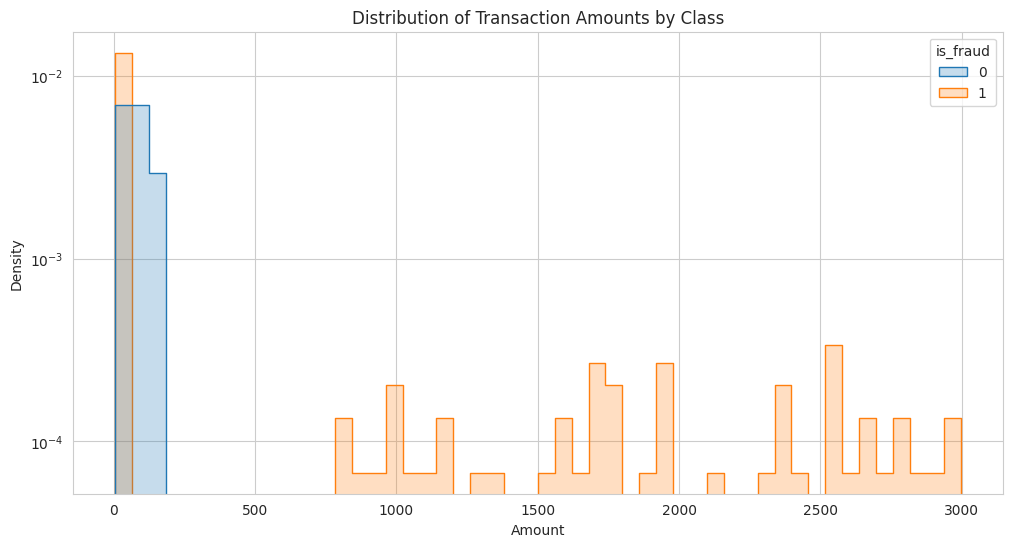

In [8]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))

# Plotting distributions of transaction amounts
sns.histplot(data=final_df, x='amount', hue='is_fraud', element='step', stat='density', common_norm=False, bins=50)

plt.title('Distribution of Transaction Amounts by Class')
plt.xlabel('Amount')
plt.yscale('log') # Use a log scale to see the distribution of smaller amounts more clearly
plt.show()

## Step 5: Feature Engineering (Stream Simulation)

This is the most critical step. We need to create features for our model. To avoid **training-serving skew**, we must generate our training features in the *exact same way* we will in our real-time Flink application.

We will iterate through our time-sorted DataFrame as if it were a live stream of events. For each transaction, we'll calculate features based on the user's history up to that point.

Our features will be:
1.  **`amount`**: The transaction amount itself.
2.  **`time_since_last_tx_seconds`**: The time difference between the current and the user's previous transaction.
3.  **`avg_amount_last_5_tx`**: The user's average transaction amount over their last 5 transactions.

In [9]:
# This dictionary will act as our state store, just like Flink's state
user_history = {}

features = []

print("Simulating stream and engineering features...")

# Iterate through the DataFrame row by row
for index, row in final_df.iterrows():
    user_id = row['user_id']
    current_time = row['timestamp']
    amount = row['amount']
    
    # Initialize state for new users
    if user_id not in user_history:
        user_history[user_id] = {
            'last_tx_time': current_time,
            'amounts': [amount]
        }
        # For the first transaction, we use default/neutral values
        time_since_last_tx_seconds = 0
        avg_amount_last_5_tx = amount
    else:
        # Calculate time since last transaction
        time_diff = current_time - user_history[user_id]['last_tx_time']
        time_since_last_tx_seconds = time_diff.total_seconds()
        
        # Calculate average amount of last 5 transactions
        last_5_amounts = user_history[user_id]['amounts'][-5:]
        avg_amount_last_5_tx = sum(last_5_amounts) / len(last_5_amounts)
        
        # Update user history
        user_history[user_id]['last_tx_time'] = current_time
        user_history[user_id]['amounts'].append(amount)
        # Keep the list of amounts from growing too large
        if len(user_history[user_id]['amounts']) > 5:
            user_history[user_id]['amounts'].pop(0)
            
    features.append([
        amount,
        time_since_last_tx_seconds,
        avg_amount_last_5_tx
    ])

# Create a new DataFrame with the engineered features
features_df = pd.DataFrame(features, columns=['amount', 'time_since_last_tx_seconds', 'avg_amount_last_5_tx'])

print(f"Created {len(features_df)} feature vectors.")
features_df.head()

Simulating stream and engineering features...
Created 10248 feature vectors.


,amount,time_since_last_tx_seconds,avg_amount_last_5_tx
0,66.20,0.0,66.20
1,102.26,0.0,102.26
2,143.68,0.0,143.68
3,22.88,0.0,22.88
4,145.57,0.0,145.57


## Step 6: Train and Save the Anomaly Detection Model

Now that we have our features, we can train our `IsolationForest` model. This is an unsupervised learning algorithm that is excellent for anomaly detection. It works by "isolating" observations.

We will also scale our features using `StandardScaler`, which is a common best practice for distance-based algorithms.

In [10]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(features_df)

# Calculate the contamination parameter
# This is the proportion of fraudulent transactions in our dataset
contamination = final_df['is_fraud'].sum() / len(final_df)
print(f"Calculated contamination: {contamination:.4f}")

# Train the Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
model.fit(X_train)

print("Model training complete.")

# --- Save the model and the scaler ---
# We need to save the scaler as well, so we can apply the exact same transformation in production
model_dir = "../flink_app/model/"
joblib.dump(model, f'{model_dir}isolation_forest.joblib')
joblib.dump(scaler, f'{model_dir}scaler.joblib')

print(f"Model and scaler saved to {model_dir}")

Calculated contamination: 0.0242
Model training complete.
Model and scaler saved to ../flink_app/model/
